# Importing Required Modules

In [61]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import matplotlib.pyplot as plt
from IPython.display import display
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

# Reading CSV File and Creating the Dataframe

In [2]:
df = pd.read_csv('/home/govind/project/data/combined_data.csv')

In [3]:
df.head()

,Label,Text
0,1,I feel like I am drowning. #depression #anxiet...
1,1,I get so nervous even thinking about talking t...
2,1,I lost my blinders .... #panic
3,1,I feel like I am drowning. #depression #falur...
4,1,This is the scariest American Horror Story out...


# Plotting the Distribution of Different Classes

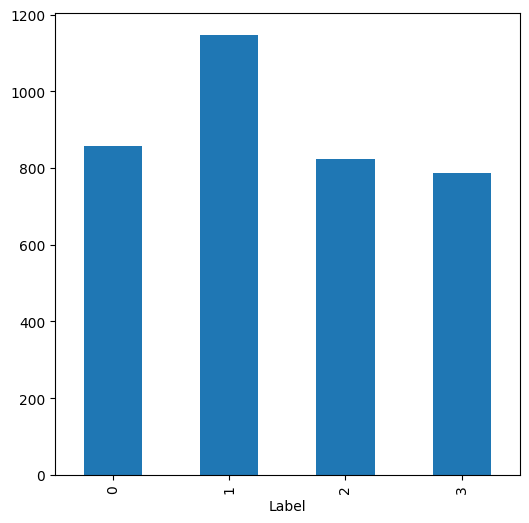

In [4]:
fig = plt.figure(figsize=(6,6))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

# Creating Embeddings for Text Sentences

In [5]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df.Text).toarray()
labels = df.Label
print(features.shape)
print(labels.shape)

(3613, 1212)
(3613,)


# Splitting the Data into Test, Train


In [6]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.20)

# Converting Dataframes into Numpy arrays

In [7]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Creating Labels Dictionary

In [8]:
emotion_dict = {'anger': 0,
                'fear': 1,
                'joy': 2,
                'sadness': 3}

emo_keys = list(['anger', 'fear', 'joy', 'sadness'])


# Function for Calculating Confusion Matrix

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# One Hot encoding for True Labels

In [10]:
def one_hot_encoder(true_labels, num_classes):
    num_records = true_labels.shape[0] 
    true_labels_one_hot = np.zeros((num_records, num_classes))
    true_labels_one_hot[np.arange(num_records), true_labels] = 1
    return torch.tensor(true_labels_one_hot, dtype=torch.float32)

# Function for calculating Metrics

In [11]:
def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

# Creating Architecture of Neural Network

In [40]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1212, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 4)
        
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x, dim=1)

# Checking Whether GPU is available or not

In [46]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Setting the Hyper-Parameters

In [47]:
input_size =1212  # or 1212, depending on the size of your vector embeddings
hidden_size = 128
num_layers = 2
num_classes = 4
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# Converting numpy arrays into Tensor 

In [48]:
X_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

/tmp/ipykernel_1248234/784999118.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long)
/tmp/ipykernel_1248234/784999118.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long)


# Preparing DataLoader for Model Training

In [49]:
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model intialization

In [52]:
model = MLP()  
model=model.to(device)

# LossFunction and Optimizer

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop and Saving the Model after training

In [55]:
for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        
        # Convert target labels to one-hot encoding
        one_hot_true = one_hot_encoder(targets.detach().cpu().numpy(), num_classes).to(device)
        
        # Forward pass
        scores = model(data)
        loss = criterion(scores, one_hot_true)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    torch.save(model.state_dict(), '/home/govind/project/models/deep_learning_model.pkl')


# Model Evaluation

In [56]:
pretrained_model = MLP()
pretrained_model.load_state_dict(torch.load('/home/govind/project/models/deep_learning_model.pkl'))
pretrained_model.eval()

MLP(
  (fc1): Linear(in_features=1212, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=4, bias=True)
)

In [72]:
predictions=pretrained_model.forward(X_test)
predictions=predictions.detach().cpu().numpy()
predictions = np.argmax(predictions, axis=1)

# Performance of Trianed Model on Test Data

Test Set Accuracy =  0.780
Test Set F-score =  0.774
Test Set Precision =  0.781
Test Set Recall =  0.771
Confusion matrix, without normalization
[[128  13   4  15]
 [ 19 201   7  13]
 [  6  18 138   5]
 [ 16  31  12  97]]


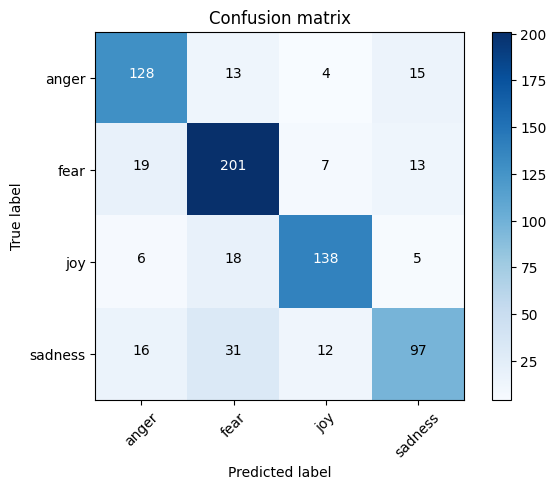

In [73]:

one_hot_true = one_hot_encoder(y_test,4)
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, predictions)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, predictions, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, predictions, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, predictions, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, predictions), classes=emotion_dict.keys())